# Description

Combines all gene enrichment results found in input directory.

# Modules loading

In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from clustermatch import conf

# Settings

In [2]:
# ENRICH_FUNCTION = "enrichGO"

In [3]:
# CORRELATION_METHOD_NAME = "clustermatch"

In [4]:
# GENE_SELECTION_STRATEGY = "var_pc_log2"

In [5]:
# # clusterProfiler settings
# ENRICH_FUNCTION = "enrichGO"
# SIMPLIFY_CUTOFF = 0.7
# GO_ONTOLOGIES = ("BP", "CC", "MF")

In [6]:
# SIMILARITY_MATRICES_DIR = conf.GTEX["SIMILARITY_MATRICES_DIR"]
# display(SIMILARITY_MATRICES_DIR)

In [7]:
# SIMILARITY_MATRIX_FILENAME_TEMPLATE = conf.GTEX["SIMILARITY_MATRIX_FILENAME_TEMPLATE"]
# display(SIMILARITY_MATRIX_FILENAME_TEMPLATE)

# Paths

In [8]:
INPUT_DIR = conf.GTEX["GENE_ENRICHMENT_DIR"]
display(INPUT_DIR)
assert INPUT_DIR.exists()

PosixPath('/home/miltondp/projects/labs/greenelab/clustermatch_repos/clustermatch-gene-expr/base/results/gtex_v8/gene_set_enrichment')

In [9]:
OUTPUT_FILE = conf.GTEX["GENE_ENRICHMENT_COMBINED_FILE"]
display(OUTPUT_FILE)

OUTPUT_FILE.parent.mkdir(parents=True, exist_ok=True)

PosixPath('/home/miltondp/projects/labs/greenelab/clustermatch_repos/clustermatch-gene-expr/base/results/gtex_v8/gene_set_enrichment/gtex_v8_data-gene_set_enrichment.pkl')

# Get data files

In [10]:
filename_pattern = re.compile(conf.GTEX["GENE_ENRICHMENT_FILENAME_PATTERN"])

In [11]:
# get input data files according to Settings
input_files = sorted(
    [
        f
        for f in INPUT_DIR.iterdir()
        if (m := re.search(filename_pattern, str(f))) is not None
        #         and m.group("corr_method") == CORRELATION_METHOD_NAME
    ]
)
display(len(input_files))
display(input_files[:5])

assert len(input_files) > 0

90

[PosixPath('/home/miltondp/projects/labs/greenelab/clustermatch_repos/clustermatch-gene-expr/base/results/gtex_v8/gene_set_enrichment/gtex_v8_data_adipose_subcutaneous-var_pc_log2-clustermatch-SpectralClustering-enrichGO-BP_full.pkl'),
 PosixPath('/home/miltondp/projects/labs/greenelab/clustermatch_repos/clustermatch-gene-expr/base/results/gtex_v8/gene_set_enrichment/gtex_v8_data_adipose_subcutaneous-var_pc_log2-clustermatch-SpectralClustering-enrichGO-BP_simplified_070.pkl'),
 PosixPath('/home/miltondp/projects/labs/greenelab/clustermatch_repos/clustermatch-gene-expr/base/results/gtex_v8/gene_set_enrichment/gtex_v8_data_adipose_subcutaneous-var_pc_log2-clustermatch-SpectralClustering-enrichGO-CC_full.pkl'),
 PosixPath('/home/miltondp/projects/labs/greenelab/clustermatch_repos/clustermatch-gene-expr/base/results/gtex_v8/gene_set_enrichment/gtex_v8_data_adipose_subcutaneous-var_pc_log2-clustermatch-SpectralClustering-enrichGO-CC_simplified_070.pkl'),
 PosixPath('/home/miltondp/projects/

## Preview data

In [12]:
display(input_files[0])

PosixPath('/home/miltondp/projects/labs/greenelab/clustermatch_repos/clustermatch-gene-expr/base/results/gtex_v8/gene_set_enrichment/gtex_v8_data_adipose_subcutaneous-var_pc_log2-clustermatch-SpectralClustering-enrichGO-BP_full.pkl')

In [13]:
_tmp_df = pd.read_pickle(input_files[0])

In [14]:
_tmp_df.shape

(50515, 12)

In [15]:
_tmp_df.sample(n=5, random_state=0)

,Cluster,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,clustering_id,clustering_n_clusters
17492,C21,GO:0035383,thioester metabolic process,15/329,34/3528,9.214483e-08,6.388708e-06,5.708822e-06,FASN/ACSL1/ACACB/ACOT1/ACSM5/ELOVL5/SLC25A1/AA...,15,SpectralClustering #13,65
25252,C60,GO:0032103,positive regulation of response to external st...,14/114,170/3528,9.718798e-04,1.609940e-02,1.372641e-02,CD209/CLEC10A/CSF1R/TYROBP/AIF1/CD28/P2RY12/BT...,14,SpectralClustering #16,80
38316,C1,GO:0071398,cellular response to fatty acid,3/20,19/3528,1.425567e-04,9.785604e-03,8.874987e-03,AKR1C2/AKR1C1/AKR1C3,3,SpectralClustering #21,125
3849,C3,GO:0045321,leukocyte activation,45/93,490/3528,5.381953e-16,1.085833e-15,5.068876e-16,IGHG2/IGKC/IGLC1/IGHG1/IGHG3/IGHM/IGHA1/IGLC3/...,45,SpectralClustering #4,20
26471,C36,GO:0060627,regulation of vesicle-mediated transport,3/7,129/3528,1.500944e-03,1.795773e-02,9.874634e-03,FGB/APOC3/FGG,3,SpectralClustering #16,80


# Run

## Read data, convert dtypes, add new metrics

In [16]:
all_results = []

for f_full in tqdm(input_files, ncols=100):
    f_name = f_full.name

    f_data = pd.read_pickle(f_full)
    f_data = f_data.rename(
        columns={
            "Count": "gene_count",
            "GeneRatio": "gene_ratio",
            "BgRatio": "bg_ratio",
            "ID": "go_term_id",
            "Description": "go_term_desc",
            "Cluster": "cluster_id",
            "clustering_n_clusters": "n_clusters",
            "p.adjust": "fdr",
        }
    )

    # genes in cluster
    f_data = f_data.assign(
        gene_total=f_data["gene_ratio"].apply(lambda x: int(x.split("/")[1]))
    )

    # background genes
    f_data = f_data.assign(
        bg_count=f_data["bg_ratio"].apply(lambda x: int(x.split("/")[0]))
    )
    f_data = f_data.assign(
        bg_total=f_data["bg_ratio"].apply(lambda x: int(x.split("/")[1]))
    )

    # add metadata
    metadata = re.search(filename_pattern, f_name)

    f_data = f_data[
        [
            "n_clusters",
            "cluster_id",
            "go_term_id",
            "go_term_desc",
            "gene_count",
            "gene_total",
            "gene_ratio",
            "bg_count",
            "bg_total",
            "bg_ratio",
            "fdr",
        ]
    ]

    f_data["tissue"] = metadata.group("tissue")
    f_data["gene_sel_strategy"] = metadata.group("gene_sel_strategy")
    f_data["corr_method"] = metadata.group("corr_method")
    f_data["clust_method"] = metadata.group("clust_method")
    f_data["enrich_func"] = metadata.group("enrich_func")
    f_data["results_subset"] = metadata.group("results_subset")

    all_results.append(f_data)

100%|███████████████████████████████████████████████████████████████| 90/90 [00:04<00:00, 21.96it/s]


In [17]:
df = pd.concat(all_results, ignore_index=True)

# to category dtype
df["cluster_id"] = df["cluster_id"].astype("category")
df["go_term_id"] = df["go_term_id"].astype("category")
df["go_term_desc"] = df["go_term_desc"].astype("category")
df["tissue"] = df["tissue"].astype("category")
df["gene_sel_strategy"] = df["gene_sel_strategy"].astype("category")
df["corr_method"] = df["corr_method"].astype("category")
df["clust_method"] = df["clust_method"].astype("category")
df["enrich_func"] = df["enrich_func"].astype("category")
df["results_subset"] = df["results_subset"].astype("category")

# convert to int32
df["n_clusters"] = df["n_clusters"].astype("int32")
df["gene_count"] = df["gene_count"].astype("int32")
df["gene_total"] = df["gene_total"].astype("int32")
df["bg_count"] = df["bg_count"].astype("int32")
df["bg_total"] = df["bg_total"].astype("int32")

# convert ratios to numbers
df["gene_ratio"] = df["gene_count"].div(df["gene_total"])
df["bg_ratio"] = df["bg_count"].div(df["bg_total"])

# add other metrics
df["rich_factor"] = df["gene_count"].div(df["bg_count"])
df["fold_enrich"] = df["gene_ratio"].div(df["bg_ratio"])

In [18]:
df.shape

(1333944, 19)

In [19]:
display(df.dtypes)
assert df.dtypes.loc["cluster_id"] == "category"

n_clusters              int32
cluster_id           category
go_term_id           category
go_term_desc         category
gene_count              int32
gene_total              int32
gene_ratio            float64
bg_count                int32
bg_total                int32
bg_ratio              float64
fdr                   float64
tissue               category
gene_sel_strategy    category
corr_method          category
clust_method         category
enrich_func          category
results_subset       category
rich_factor           float64
fold_enrich           float64
dtype: object

In [20]:
df.sample(n=5)

,n_clusters,cluster_id,go_term_id,go_term_desc,gene_count,gene_total,gene_ratio,bg_count,bg_total,bg_ratio,fdr,tissue,gene_sel_strategy,corr_method,clust_method,enrich_func,results_subset,rich_factor,fold_enrich
912872,10,C6,GO:0070161,anchoring junction,112,1124,0.099644,247,3531,0.069952,0.000151,skin_sun_exposed_lower_leg,var_pc_log2,pearson_abs,SpectralClustering,enrichGO,CC_full,0.453441,1.424467
689045,175,C66,GO:0042509,regulation of tyrosine phosphorylation of STAT...,1,2,0.500000,22,3746,0.005873,0.044128,muscle_skeletal,var_pc_log2,spearman_abs,SpectralClustering,enrichGO,BP_full,0.045455,85.136364
1025533,50,C5,GO:0005198,structural molecule activity,4,10,0.400000,234,3341,0.070039,0.015242,skin_sun_exposed_lower_leg,var_pc_log2,spearman_abs,SpectralClustering,enrichGO,MF_full,0.017094,5.711111
116739,70,C32,GO:0019731,antibacterial humoral response,2,12,0.166667,26,3528,0.007370,0.004832,adipose_subcutaneous,var_pc_log2,pearson_abs,SpectralClustering,enrichGO,BP_full,0.076923,22.615385
160461,85,C15,GO:0019724,B cell mediated immunity,5,7,0.714286,117,3528,0.033163,0.000010,adipose_subcutaneous,var_pc_log2,pearson_abs,SpectralClustering,enrichGO,BP_simplified_070,0.042735,21.538462


## Some stats

In [21]:
display(df["fdr"].describe())
assert df["fdr"].min() > 0.0
assert df["fdr"].max() < 1.0

count     1.333944e+06
mean      1.359243e-02
std       1.566511e-02
min      6.807472e-203
25%       1.249015e-04
50%       5.882928e-03
75%       2.548727e-02
max       4.999997e-02
Name: fdr, dtype: float64

In [22]:
df["n_clusters"].unique()

array([  2,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 125, 150, 175, 200],
      dtype=int32)

In [23]:
df["tissue"].unique()

['adipose_subcutaneous', 'artery_tibial', 'muscle_skeletal', 'skin_sun_exposed_lower_leg', 'whole_blood']
Categories (5, object): ['adipose_subcutaneous', 'artery_tibial', 'muscle_skeletal', 'skin_sun_exposed_lower_leg', 'whole_blood']

In [24]:
df["gene_sel_strategy"].unique()

['var_pc_log2']
Categories (1, object): ['var_pc_log2']

In [25]:
df["corr_method"].unique()

['clustermatch', 'pearson_abs', 'spearman_abs']
Categories (3, object): ['clustermatch', 'pearson_abs', 'spearman_abs']

In [26]:
df["clust_method"].unique()

['SpectralClustering']
Categories (1, object): ['SpectralClustering']

In [27]:
df["results_subset"].unique()

['BP_full', 'BP_simplified_070', 'CC_full', 'CC_simplified_070', 'MF_full', 'MF_simplified_070']
Categories (6, object): ['BP_full', 'BP_simplified_070', 'CC_full', 'CC_simplified_070', 'MF_full', 'MF_simplified_070']

## Testing

In [28]:
assert not df.isna().any().any()

In [29]:
# test if values are correctly calculated
_tmp = df[
    (df.go_term_id == "GO:0035383")
    & (df.n_clusters == 65)
    & (df.cluster_id == "C21")
    & (df.tissue == "adipose_subcutaneous")
    & (df.gene_sel_strategy == "var_pc_log2")
    & (df.corr_method == "clustermatch")
    & (df.clust_method == "SpectralClustering")
    & (df.enrich_func == "enrichGO")
    & (df.results_subset == "BP_full")
]
assert _tmp.shape[0] == 1
_tmp = _tmp.iloc[0]

assert _tmp["gene_count"] == 15
assert _tmp["gene_total"] == 329
assert _tmp["gene_ratio"] == 15.0 / 329.0
assert _tmp["bg_count"] == 34
assert _tmp["bg_total"] == 3528
assert _tmp["bg_ratio"] == 34.0 / 3528.0
assert _tmp["rich_factor"] == 15.0 / 34.0
assert _tmp["fold_enrich"] == (15.0 / 329.0) / (34.0 / 3528.0)

# Save

In [30]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

saveRDS = ro.r["saveRDS"]
readRDS = ro.r["readRDS"]

In [31]:
data = df

## Pickle

In [32]:
display(OUTPUT_FILE)

PosixPath('/home/miltondp/projects/labs/greenelab/clustermatch_repos/clustermatch-gene-expr/base/results/gtex_v8/gene_set_enrichment/gtex_v8_data-gene_set_enrichment.pkl')

In [33]:
data.to_pickle(OUTPUT_FILE)

## RDS

In [34]:
output_rds_file = OUTPUT_FILE.with_suffix(".rds")
display(output_rds_file)

PosixPath('/home/miltondp/projects/labs/greenelab/clustermatch_repos/clustermatch-gene-expr/base/results/gtex_v8/gene_set_enrichment/gtex_v8_data-gene_set_enrichment.rds')

In [35]:
with localconverter(ro.default_converter + pandas2ri.converter):
    data_r = ro.conversion.py2rpy(data)

In [36]:
data_r

n_clusters,cluster_id,go_term_id,...,results_subset,rich_factor,fold_enrich
2,C0,GO:00...,...,BP_full,0.509804,3.438983
2,C0,GO:00...,,BP_full,0.588462,3.969584
2,C0,GO:00...,,BP_full,0.439331,2.963591
2,C0,GO:00...,,BP_full,0.478495,3.227780
...,...,...,,...,...,...
200,C146,GO:19...,,MF_si...,0.016949,33.347458
200,C126,GO:00...,,MF_si...,0.222222,8.922902
200,C0,GO:00...,,MF_si...,0.009259,36.435185
200,C139,GO:00...,,MF_si...,0.006369,25.063694


In [37]:
saveRDS(data_r, str(output_rds_file))

<rpy2.rinterface_lib.sexp.NULLType object at 0x7fdab2080d80> [RTYPES.NILSXP]

In [38]:
# testing
data_r = readRDS(str(output_rds_file))

In [39]:
with localconverter(ro.default_converter + pandas2ri.converter):
    data_again = ro.conversion.rpy2py(data_r)

    # convert index to int, otherwise it's converted to string
    data_again.index = data_again.index.astype(int)

In [40]:
data_again.shape

(1333944, 19)

In [41]:
data_again.head()

,n_clusters,cluster_id,go_term_id,go_term_desc,gene_count,gene_total,gene_ratio,bg_count,bg_total,bg_ratio,fdr,tissue,gene_sel_strategy,corr_method,clust_method,enrich_func,results_subset,rich_factor,fold_enrich
0,2,C0,GO:0002443,leukocyte mediated immunity,182,523,0.347992,357,3528,0.101190,5.513573e-64,adipose_subcutaneous,var_pc_log2,clustermatch,SpectralClustering,enrichGO,BP_full,0.509804,3.438983
1,2,C0,GO:0002250,adaptive immune response,153,523,0.292543,260,3528,0.073696,5.619467e-64,adipose_subcutaneous,var_pc_log2,clustermatch,SpectralClustering,enrichGO,BP_full,0.588462,3.969584
2,2,C0,GO:0002252,immune effector process,210,523,0.401530,478,3528,0.135488,1.899014e-61,adipose_subcutaneous,var_pc_log2,clustermatch,SpectralClustering,enrichGO,BP_full,0.439331,2.963591
3,2,C0,GO:0050776,regulation of immune response,178,523,0.340344,372,3528,0.105442,2.790792e-57,adipose_subcutaneous,var_pc_log2,clustermatch,SpectralClustering,enrichGO,BP_full,0.478495,3.227780
4,2,C0,GO:0006909,phagocytosis,112,523,0.214149,171,3528,0.048469,3.019211e-52,adipose_subcutaneous,var_pc_log2,clustermatch,SpectralClustering,enrichGO,BP_full,0.654971,4.418235


In [45]:
pd.testing.assert_frame_equal(
    data,
    data_again,
    check_names=False,  # do not check "name" attribute of index and column
    check_exact=True,  # since this is a binary format, it should match exactly
)

## tsv.gz

In [46]:
output_text_file = OUTPUT_FILE.with_suffix(".tsv.gz")
display(output_text_file)

PosixPath('/home/miltondp/projects/labs/greenelab/clustermatch_repos/clustermatch-gene-expr/base/results/gtex_v8/gene_set_enrichment/gtex_v8_data-gene_set_enrichment.tsv.gz')

In [ ]:
data.to_csv(output_text_file, sep="\t", index=False, float_format="%.5e")

In [ ]:
# testing
data_again = pd.read_csv(output_text_file, sep="\t")  # , index_col=0)

In [ ]:
data_again.shape

In [ ]:
data_again.head()

In [ ]:
pd.testing.assert_frame_equal(
    data,
    data_again,
    check_names=False,  # do not check "name" attribute of index and column
    check_dtype=False,  # do not check dtypes: do not distinguish between int64 and int32, for instance
    check_categorical=False,
    check_exact=False,
    rtol=0.0,
    atol=5e-4,
)

# QQ plot

In [25]:
PERFORMANCE_MEASURE = "fdr"

In [26]:
QUANTILES = np.linspace(0, 1, 10000)
display(QUANTILES[:10])
display(QUANTILES[-10:])

array([0.        , 0.00010001, 0.00020002, 0.00030003, 0.00040004,
       0.00050005, 0.00060006, 0.00070007, 0.00080008, 0.00090009])

array([0.99909991, 0.99919992, 0.99929993, 0.99939994, 0.99949995,
       0.99959996, 0.99969997, 0.99979998, 0.99989999, 1.        ])

In [27]:
df["results_subset"].unique()

['BP_full', 'BP_simplified_070', 'CC_full', 'CC_simplified_070', 'MF_full', 'MF_simplified_070']
Categories (6, object): ['BP_full', 'BP_simplified_070', 'CC_full', 'CC_simplified_070', 'MF_full', 'MF_simplified_070']

In [28]:
df_subset = df[
    #     (df.tissue == "whole_blood")
    (df.gene_sel_strategy == "var_pc_log2")
    & (df.clust_method == "SpectralClustering")
    & (df.enrich_func == "enrichGO")
    & (df.results_subset == "BP_simplified_070")
]

In [29]:
df_subset.shape

(289179, 19)

In [30]:
df_subset.head()

,n_clusters,cluster_id,go_term_id,go_term_desc,gene_count,gene_total,gene_ratio,bg_count,bg_total,bg_ratio,fdr,tissue,gene_sel_strategy,corr_method,clust_method,enrich_func,results_subset,rich_factor,fold_enrich
50515,2,C0,GO:0002443,leukocyte mediated immunity,182,523,0.347992,357,3528,0.101190,5.513573e-64,adipose_subcutaneous,var_pc_log2,clustermatch,SpectralClustering,enrichGO,BP_simplified_070,0.509804,3.438983
50516,2,C0,GO:0002250,adaptive immune response,153,523,0.292543,260,3528,0.073696,5.619467e-64,adipose_subcutaneous,var_pc_log2,clustermatch,SpectralClustering,enrichGO,BP_simplified_070,0.588462,3.969584
50517,2,C0,GO:0050776,regulation of immune response,178,523,0.340344,372,3528,0.105442,2.790792e-57,adipose_subcutaneous,var_pc_log2,clustermatch,SpectralClustering,enrichGO,BP_simplified_070,0.478495,3.227780
50518,2,C0,GO:0006909,phagocytosis,112,523,0.214149,171,3528,0.048469,3.019211e-52,adipose_subcutaneous,var_pc_log2,clustermatch,SpectralClustering,enrichGO,BP_simplified_070,0.654971,4.418235
50519,2,C0,GO:0002429,immune response-activating cell surface recept...,116,523,0.221797,187,3528,0.053005,1.120564e-50,adipose_subcutaneous,var_pc_log2,clustermatch,SpectralClustering,enrichGO,BP_simplified_070,0.620321,4.184497


In [31]:
df_methods = df_subset["corr_method"].unique()
display(df_methods)

['clustermatch', 'pearson_abs', 'spearman_abs']
Categories (3, object): ['clustermatch', 'pearson_abs', 'spearman_abs']

In [32]:
results_per_method = {}

for m in df_methods:
    df_values = df_subset[df_subset.corr_method == m][PERFORMANCE_MEASURE].to_numpy()
    display(f"{m} - {df_values.shape[0]}")

    if PERFORMANCE_MEASURE == "fdr":
        df_values = pd.Series(-np.log10(df_values))

    results_per_method[m] = df_values.quantile(QUANTILES)

'clustermatch - 92628'

'pearson_abs - 106296'

'spearman_abs - 90255'

In [33]:
quantiles_df = pd.DataFrame(results_per_method)

In [34]:
quantiles_df.shape

(10000, 3)

In [35]:
quantiles_df.head()

,clustermatch,pearson_abs,spearman_abs
0.0000,1.301039,1.301030,1.301071
0.0001,1.301089,1.301134,1.301168
0.0002,1.301175,1.301377,1.301295
0.0003,1.301317,1.301514,1.301514
0.0004,1.301390,1.301548,1.301647


In [36]:
quantiles_df.describe()

,clustermatch,pearson_abs,spearman_abs
count,10000.000000,10000.000000,10000.000000
mean,4.233728,4.067377,4.320075
std,7.170558,6.420876,8.528550
min,1.301039,1.301030,1.301071
25%,1.550101,1.569726,1.509439
50%,2.127880,2.172739,2.012239
75%,3.692332,3.734521,3.460900
max,116.013495,116.002979,141.840455


Text(0.5, 1.0, 'Gene Ontology (fdr)')

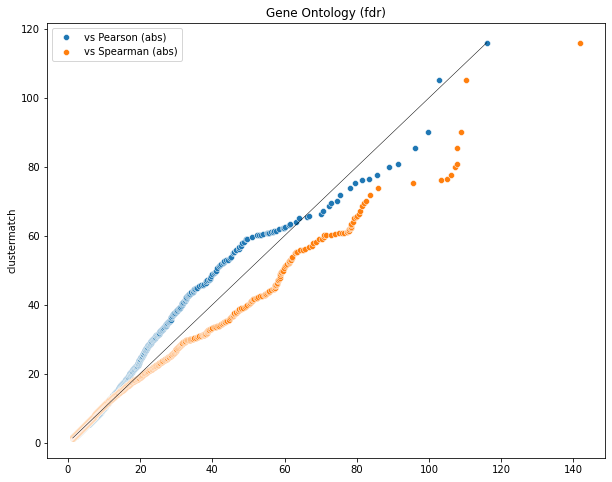

In [37]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.scatterplot(
    data=quantiles_df,
    x="pearson_abs",
    y="clustermatch",
    label="vs Pearson (abs)",
    ax=ax,
)

sns.scatterplot(
    data=quantiles_df,
    x="spearman_abs",
    y="clustermatch",
    label="vs Spearman (abs)",
    ax=ax,
)

ax.set_xlabel(None)
# ax.set_ylabel(None)

min_val = min((quantiles_df.iloc[:, 0].min(), quantiles_df.iloc[:, 1].min()))
max_val = max((quantiles_df.iloc[:, 0].max(), quantiles_df.iloc[:, 1].max()))
ax.plot([min_val, max_val], [min_val, max_val], "k", linewidth=0.5)

ax.set_title(f"Gene Ontology ({PERFORMANCE_MEASURE})")

Clustermatch (multi pattern) outperforms pearson (linear and abs), although pearson find most significant associations towards the
right end of the distribution.

However, Clustermatch does not outperform spearman (monotonic and abs), which provides more significant results across the entire distribution.